In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import surp
import matplotlib.pyplot as plt
import vice
import numpy as np
from surp.gce_math import Z_to_MH, MH_to_Z, Z_SUN, calc_y
import arya

from surp.agb_interpolator import interpolator


/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import sys
sys.path.append("../../models/")
import make_yields
from make_yields import make_yield_params, y_c_exp, y_c_lin, y_c_quad


sys.path.append("../")

from singlezone import run_singlezone

In [4]:
y_cc = vice.yields.ccsne.settings
y_agb = vice.yields.agb.settings


In [ ]:
def plot_y_z(Zs=Z_SUN * np.logspace(-1, 0.5, 100), ele="c", yields="all", kind="line", factor = 1, **kwargs):        
    y_c_agb = calc_y(Zs, ele=ele, kind=yields)
    plt.xlabel(r"$\log Z / Z_\odot$")
    plt.ylabel(r"yield")
    if kind == "line":
        p = plt.plot(Z_to_MH(Zs), y_c_agb, **kwargs)
    elif kind == "scatter":
        p = plt.scatter(Z_to_MH(Zs), y_c_agb, **kwargs)
    return p


# Parameters

In [6]:
MH = np.linspace(-1, 0.5)
Zs = MH_to_Z(MH)

In [7]:
params = make_yield_params()

0.000575064


In [13]:
AGB_LABELS = ["C11", "V13", "K16",  "P16"]


In [ ]:
for i in range(4):
    model = AGB_LABELS[i]
    yname = f"../../models/{model}_oob/yield_params.json"
    surp.set_yields(surp.YieldParams.from_file(yname), verbose=False)
    
    plot_y_z(Zs, label=model)
    
plt.plot(MH, y_c_lin(MH) * 10**0.0, label="expected", color="k")
arya.Legend(-1)

0.000143766
0.000287532
0.000575064
0.0014376600000000001


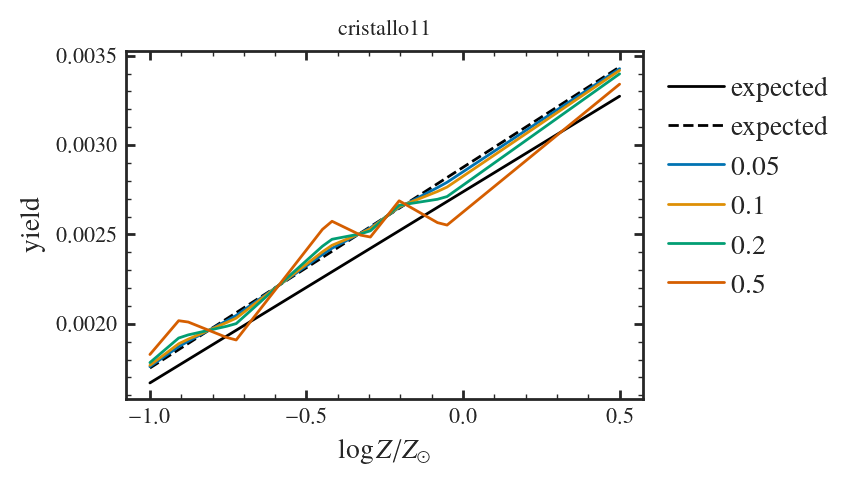

0.000143766
0.000287532
0.000575064
0.0014376600000000001


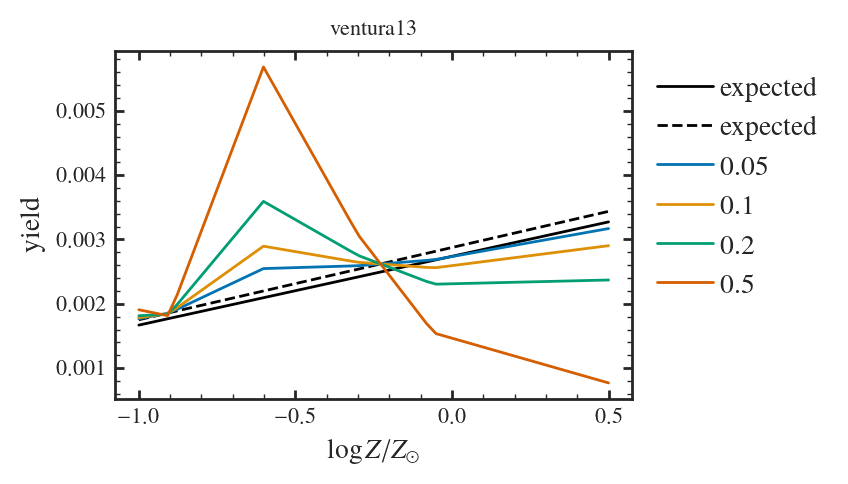

0.000143766
0.000287532
0.000575064
0.0014376600000000001


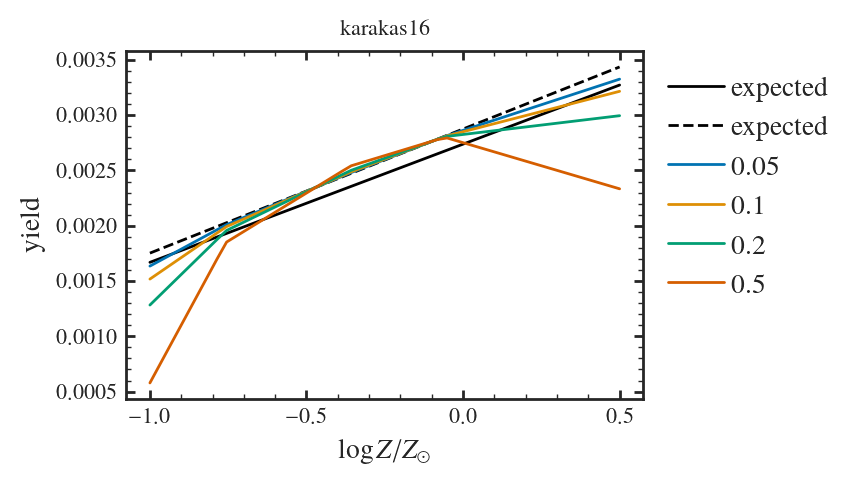

0.000143766
0.000287532
0.000575064
0.0014376600000000001


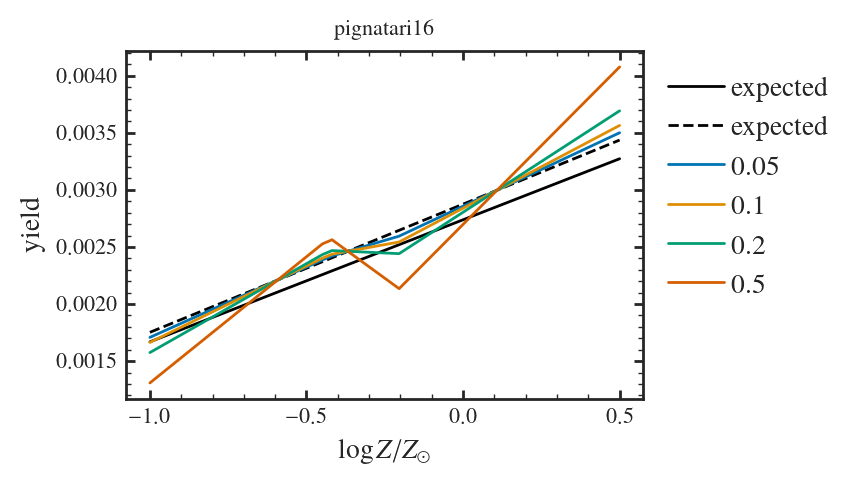

In [9]:
for agb_model in surp.AGB_MODELS:
    plt.plot(MH, y_c_lin(MH), label="expected", color="k")
    plt.plot(MH, make_yields.Y_C_0 + make_yields.ZETA_C_0 * MH, label="expected", color="k", ls="--")

    for f in [0.05, 0.1, 0.2, 0.5]:
        params = make_yield_params(f_agb=f, agb_model=agb_model, cc_model="LogLin")
        surp.yields.set_yields(params, verbose=False)
        plot_y_z(Zs, label=f)

    arya.Legend(-1)
    plt.title(agb_model)
    plt.show()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.73e-03 + 1.25e-03 (Z - Z0)   0.36 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.59e-03 + 1.37e-03 (Z - Z0)   0.72 × cristallo11          

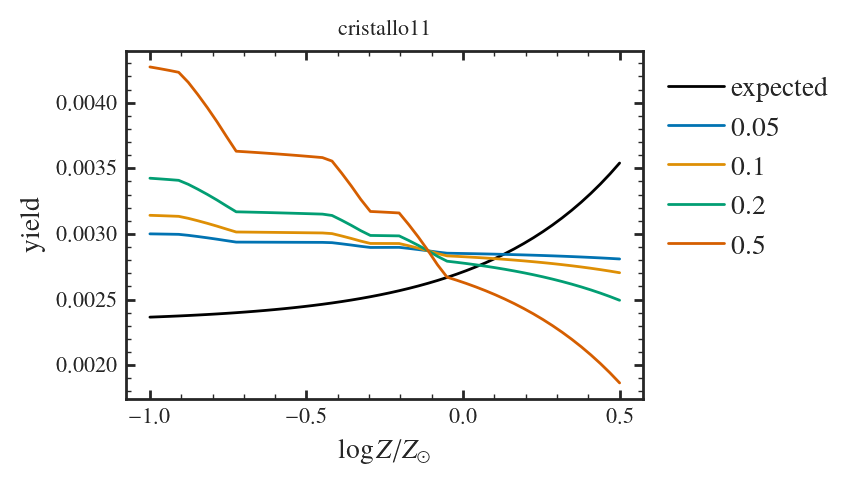

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.73e-03 + 1.39e-03 (Z - Z0)   0.55 × ventura13               0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.59e-03 + 1.66e-03 (Z - Z0)   1.11 × ventura13            

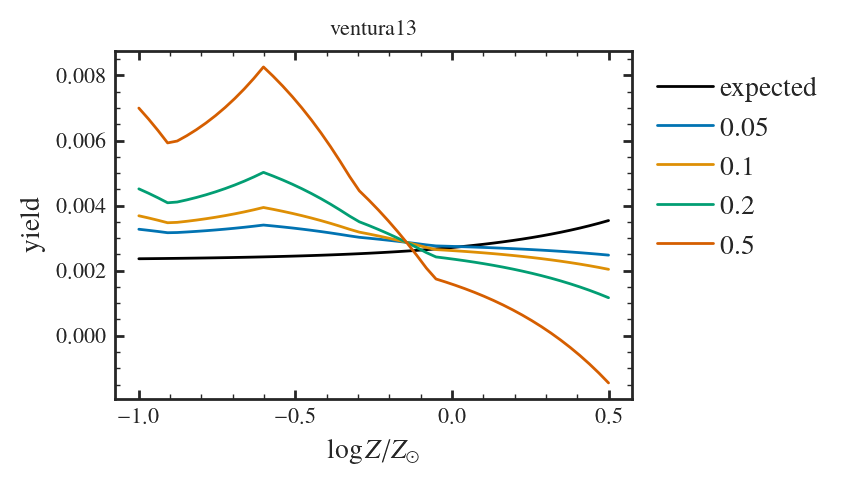

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.73e-03 + 1.53e-03 (Z - Z0)   0.41 × karakas16               0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.59e-03 + 1.94e-03 (Z - Z0)   0.82 × karakas16            

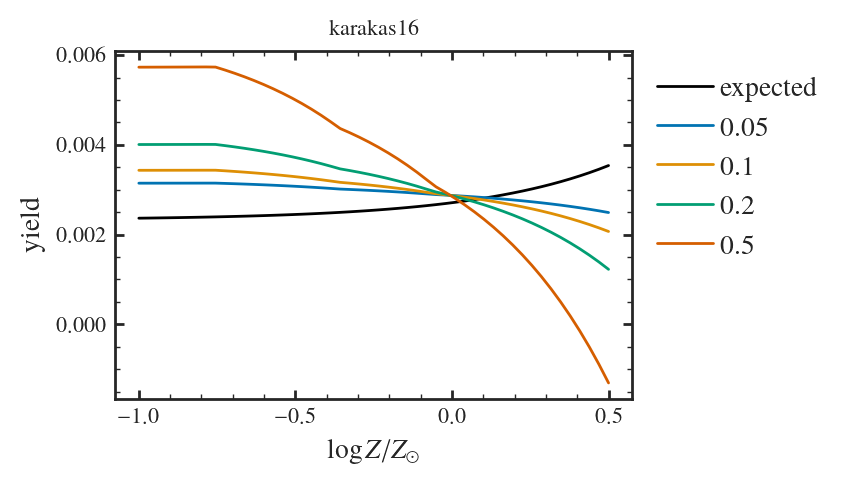

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.73e-03 + 1.19e-03 (Z - Z0)   0.18 × pignatari16             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.59e-03 + 1.25e-03 (Z - Z0)   0.36 × pignatari16          

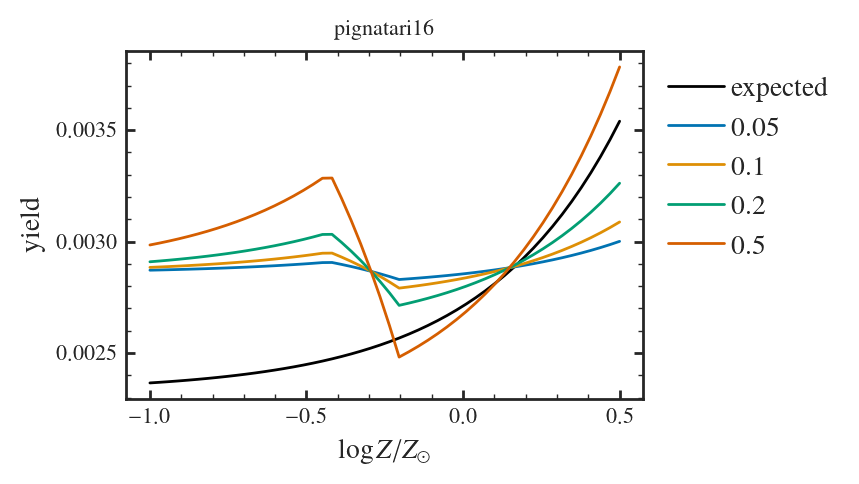

In [9]:
for agb_model in surp.AGB_MODELS:
    plt.plot(MH, y_c_exp(MH), label="expected", color="k")

    for f in [0.05, 0.1, 0.2, 0.5]:
        params = make_yield_params(f_agb=f, agb_model=agb_model, interp_kind="linear", cc_model="Lin", y1=0.002)
        surp.yields.set_yields(params)
        plot_y_z(Zs, label=f)

    arya.Legend(-1)
    plt.title(agb_model)
    plt.show()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.54e-03 (Z - Z0)   1.20 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.71e-03 (Z - Z0)   1.20 × ventura13            

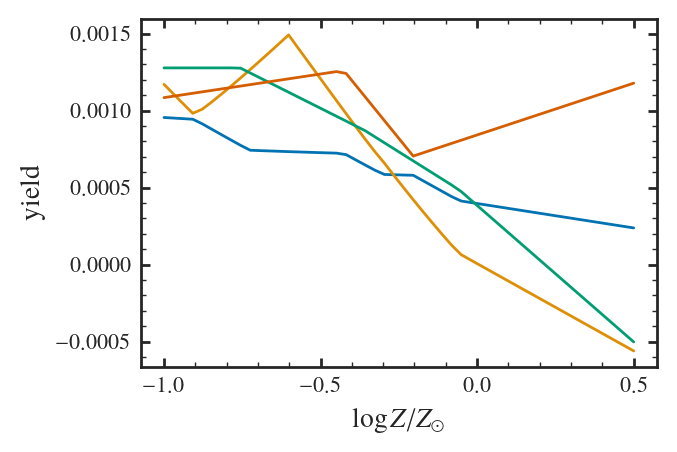

In [10]:
for model in surp._globals.AGB_MODELS:
    surp.yields.set_yields(make_yield_params(alpha_agb=1.2,  agb_model=model))
    vice.yields.ccsne.settings["c"] = 0
    plot_y_z(Zs)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 0.00e+00 (Z - Z0)   1.44 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 3.00e-02 (Z - Z0)   1.44 × cristallo11          

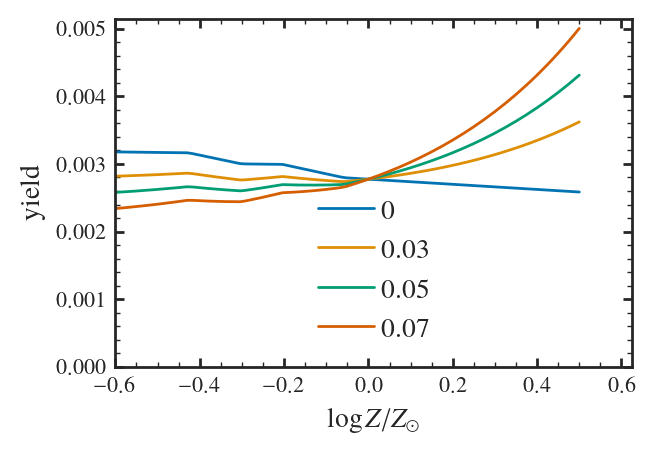

In [11]:
MH = np.linspace(-2, 0.5, 200)
Zs = MH_to_Z(MH)


for z_cc in [0, 0.03, 0.05, 0.07]:
    surp.yields.set_yields(make_yield_params(f_agb=0.2, zeta_cc=z_cc,  agb_model="cristallo11"))
    plot_y_z(Zs, label=z_cc)

plt.xlim(-0.6)
plt.ylim(0)
plt.legend()

In [12]:
MH = np.linspace(-2, 0.5, 200)
Zs = MH_to_Z(MH)
plt.plot(MH,y_c_total(Zs), label="expected", color="k")

for agb_model in surp.AGB_MODELS:

    
    params = make_yield_params(agb_model=agb_model)
    surp.yields.set_yields(params)
    plot_y_z(Zs, label=agb_model)

arya.Legend(-1)


NameError: name 'y_c_total' is not defined

In [ ]:
for model in surp.AGB_MODELS:
    vice.yields.agb.settings["c"]  = model
    plt.plot(Zs, [y_agb(Z) for Z in Zs], label="default")

    vice.yields.agb.settings["c"] = interpolator("c", study=model, no_negative=False)

    plt.plot(Zs, [y_agb(Z)  for Z in Zs], label="interpolator", ls="--")
    plt.xlabel("Z")
    plt.ylabel("y c")